In [66]:
import time
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# parameters
S0 = 4  
u = 2   
d = 0.5 
r = 0.25  
p_tilde = 0.5  
q_tilde = 0.5  
strike = 4
T = 10

In [67]:
def asian_option_recursive(n, s, y):

    if n == T:
        # Terminal payoff: max(1/4 * Y3 - 4, 0)
        return max((1/4) * y - strike, 0)
    
    us, ds = u * s, d * s
    v_up = asian_option_recursive(n + 1, us, y + us)
    v_down = asian_option_recursive(n + 1, ds, y + ds)
    return (1 / (1 + r)) * (p_tilde * v_up + q_tilde * v_down)

start = time.time()
asian_price_recursive = asian_option_recursive(0, S0, S0)
end = time.time()
asian_recursive_time = end - start

In [68]:
def european_option_recursive(n, s):
    if n == T:
        # Terminal payoff for European call: max(S - K, 0)
        return max(s - strike, 0)
    
    us, ds = u * s, d * s
    v_up = european_option_recursive(n + 1, us)
    v_down = european_option_recursive(n + 1, ds)
    return (1 / (1 + r)) * (p_tilde * v_up + q_tilde * v_down)

start = time.time()
european_price_recursive = european_option_recursive(0, S0)
end = time.time()
european_recursive_time = end - start


In [69]:
def american_option_recursive(n, s):
    if n == T:
        # Terminal payoff for American call: max(S - K, 0)
        return max(s - strike, 0)
    
    us, ds = u * s, d * s
    v_up = american_option_recursive(n + 1, us)
    v_down = american_option_recursive(n + 1, ds)
    continuation = (1 / (1 + r)) * (p_tilde * v_up + q_tilde * v_down)
    exercise = max(s - strike, 0)
    return max(continuation, exercise)

start = time.time()
american_price_recursive = american_option_recursive(0, S0)
end = time.time()
american_recursive_time = end - start

In [70]:
from functools import lru_cache

@lru_cache(None)
def asian_option_dp(n, s, y):
    if n == T:
        return max((1/4) * y - strike, 0)
    
    us, ds = u * s, d * s
    v_up = asian_option_dp(n + 1, us, y + us)
    v_down = asian_option_dp(n + 1, ds, y + ds)
    return (1 / (1 + r)) * (p_tilde * v_up + q_tilde * v_down)

start = time.time()
asian_price_dp = asian_option_dp(0, S0, S0)
end = time.time()
asian_dp_time = end - start

In [71]:
@lru_cache(None)
def european_option_dp(n, s):
    if n == T:
        return max(s - strike, 0)
    
    us, ds = u * s, d * s
    v_up = european_option_dp(n + 1, us)
    v_down = european_option_dp(n + 1, ds)
    return (1 / (1 + r)) * (p_tilde * v_up + q_tilde * v_down)

start = time.time()
european_price_dp = european_option_dp(0, S0)
end = time.time()
european_dp_time = end - start

In [72]:
@lru_cache(None)
def american_option_dp(n, s):
    if n == T:
        return max(s - strike, 0)
    
    us, ds = u * s, d * s
    v_up = american_option_dp(n + 1, us)
    v_down = american_option_dp(n + 1, ds)
    continuation = (1 / (1 + r)) * (p_tilde * v_up + q_tilde * v_down)
    exercise = max(s - strike, 0)
    return max(continuation, exercise)

start = time.time()
american_price_dp = american_option_dp(0, S0)
end = time.time()
american_dp_time = end - start

In [73]:
results = pd.DataFrame({
    "Option Type": [
        "Asian Recursive", "European Recursive", "American Recursive",
        "Asian with DP", "European with DP", "American with DP"
    ],
    "Price": [
        asian_price_recursive, european_price_recursive, american_price_recursive,
        asian_price_dp, european_price_dp, american_price_dp
    ],
    "Runtime (s)": [
        asian_recursive_time, european_recursive_time, american_recursive_time,
        asian_dp_time, european_dp_time, american_dp_time
    ]
})

# Calculate speedup and accuracy comparison
results["Speedup (Recursive vs DP)"] = results.apply(
    lambda row: "N/A" if "Recursive" in row["Option Type"] else
    results.loc[results["Option Type"] == row["Option Type"].replace("with DP", "Recursive"), "Runtime (s)"].values[0] / row["Runtime (s)"],
    axis=1
)

results["Price Difference (Recursive vs DP)"] = results.apply(
    lambda row: "N/A" if "Recursive" in row["Option Type"] else
    abs(row["Price"] - results.loc[results["Option Type"] == row["Option Type"].replace("with DP", "Recursive"), "Price"].values[0]),
    axis=1
)


print(results)

          Option Type     Price  Runtime (s) Speedup (Recursive vs DP)  \
0     Asian Recursive  4.156002     0.000416                       N/A   
1  European Recursive  3.706926     0.000513                       N/A   
2  American Recursive  3.706926     0.001667                       N/A   
3       Asian with DP  4.156002     0.000479                  0.868591   
4    European with DP  3.706926     0.000070                  7.319728   
5    American with DP  3.706926     0.000080                 20.809524   

  Price Difference (Recursive vs DP)  
0                                N/A  
1                                N/A  
2                                N/A  
3                                0.0  
4                                0.0  
5                                0.0  


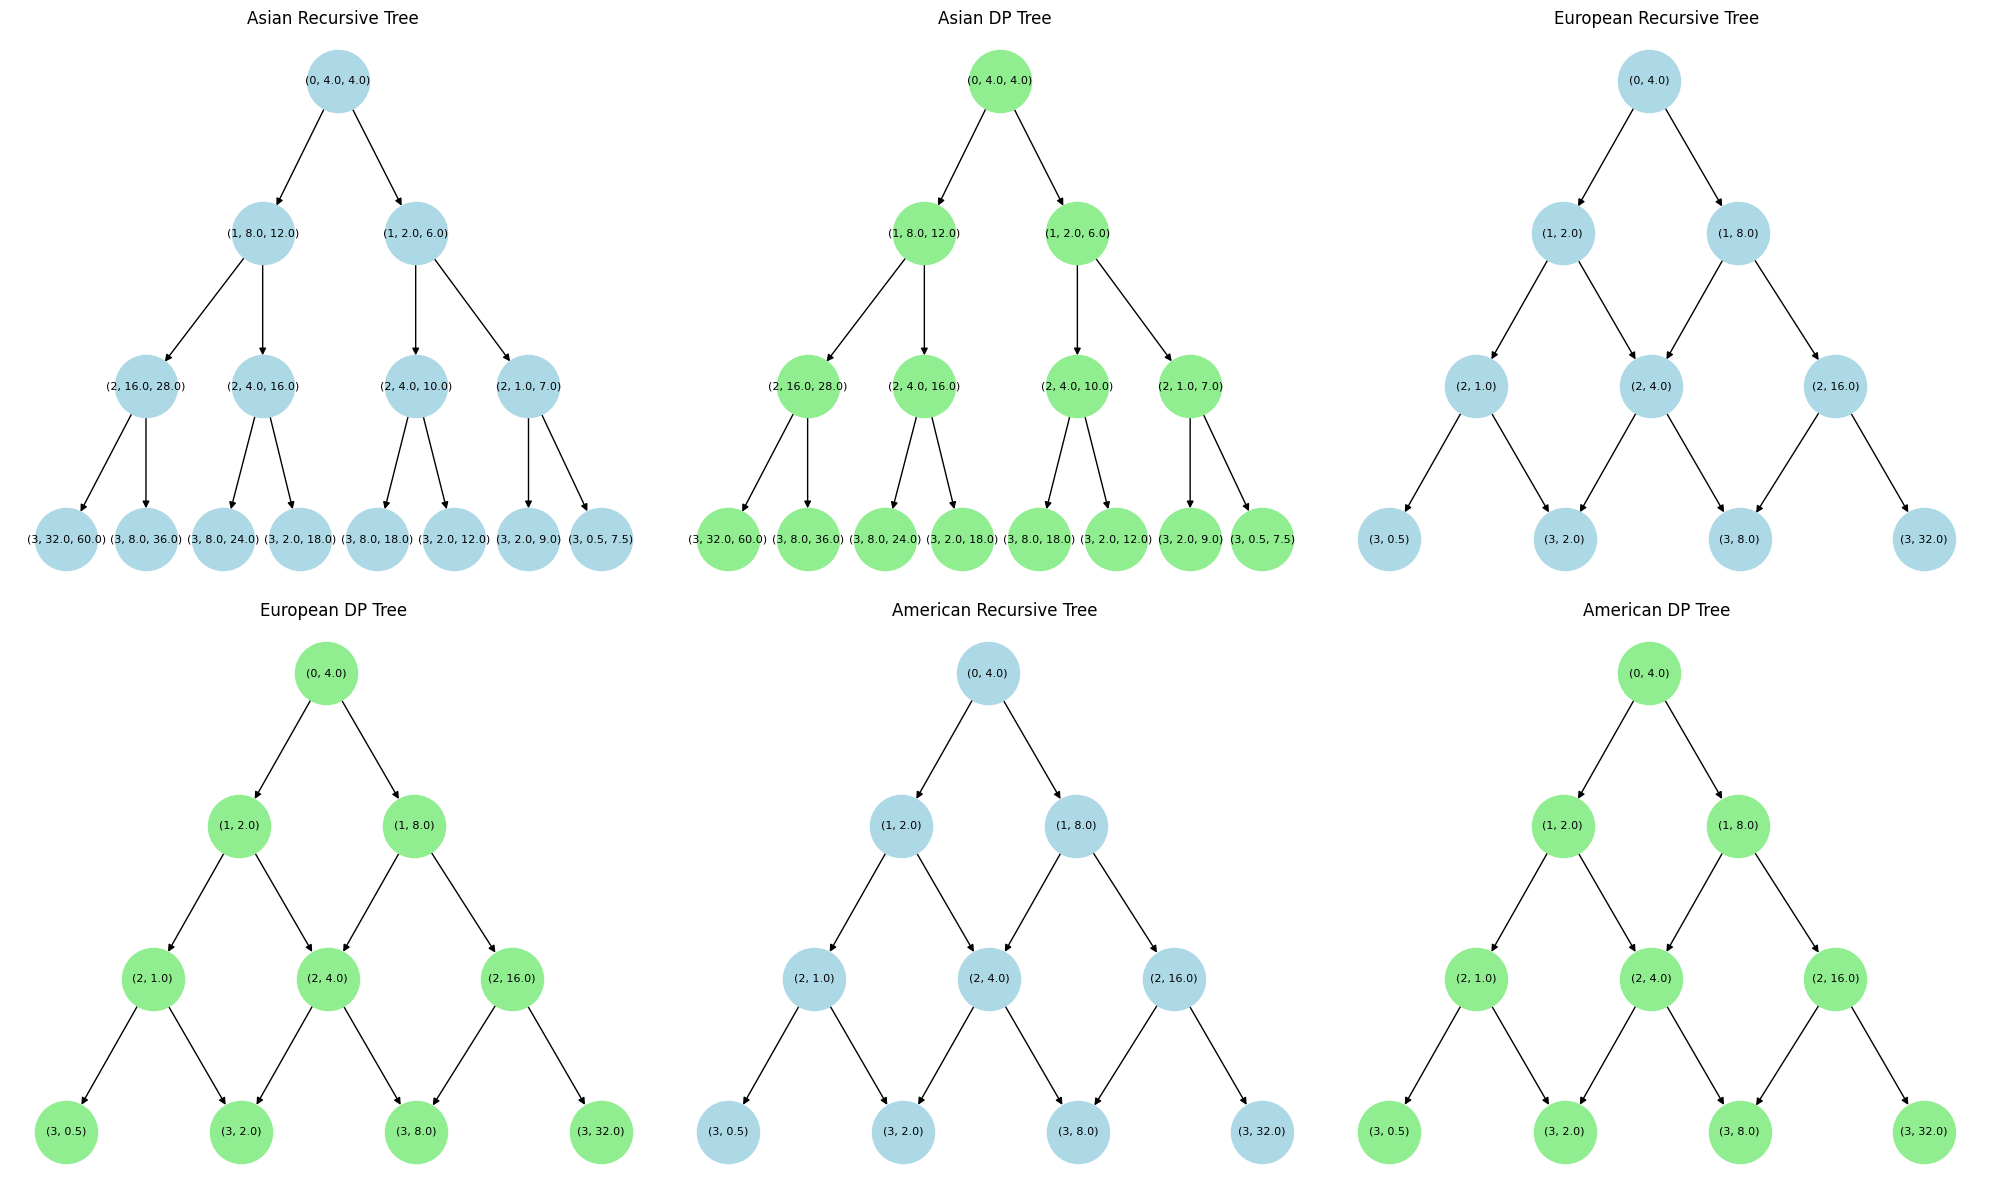

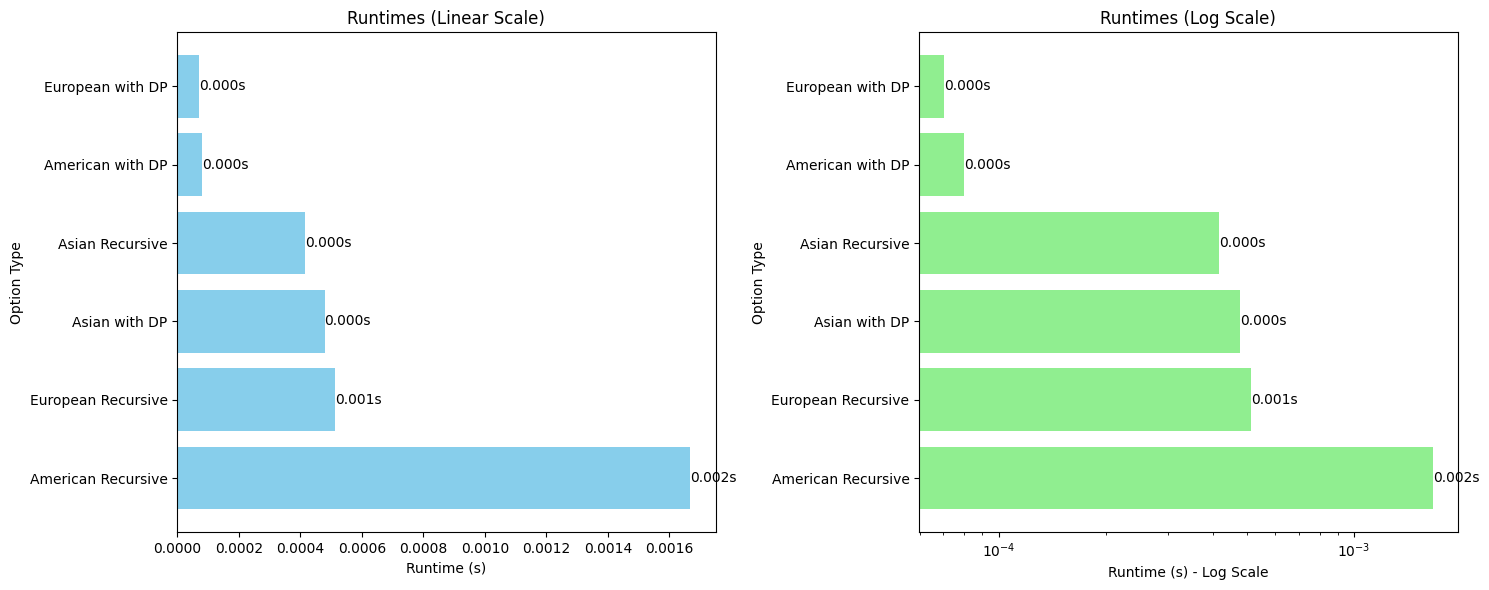

In [74]:
def build_recursive_tree(n, s, y, depth, dp_mode, graph, parent=None, cache=None):
 
    if n > depth: 
        return

    label = f"({n}, {s:.1f}, {y:.1f})"
    graph.add_node(label)

    if parent:
        graph.add_edge(parent, label) 

    if dp_mode:
        asian_option_dp(n, s, y)  
    else:
        asian_option_recursive(n, s, y)  

    # Add children recursively
    build_recursive_tree(n + 1, u * s, y + u * s, depth, dp_mode, graph, label)
    build_recursive_tree(n + 1, d * s, y + d * s, depth, dp_mode, graph, label)


def build_tree_for_option(option_type, depth=3):

    graph = nx.DiGraph()
    dp_mode = "DP" in option_type
    
    if "Asian" in option_type:
        build_recursive_tree(0, S0, S0, depth, dp_mode, graph)
    elif "European" in option_type:
        func = european_option_dp if dp_mode else european_option_recursive
        for n in range(depth + 1):
            for s in [u ** i * d ** (n - i) * S0 for i in range(n + 1)]:
                label = f"({n}, {s:.1f})"
                graph.add_node(label)
                if n > 0:
                    parent_up = f"({n-1}, {s/u:.1f})"
                    parent_down = f"({n-1}, {s/d:.1f})"
                    if parent_up in graph:
                        graph.add_edge(parent_up, label)
                    if parent_down in graph:
                        graph.add_edge(parent_down, label)
    elif "American" in option_type:
        func = american_option_dp if dp_mode else american_option_recursive
        for n in range(depth + 1):
            for s in [u ** i * d ** (n - i) * S0 for i in range(n + 1)]:
                label = f"({n}, {s:.1f})"
                graph.add_node(label)
                if n > 0:
                    parent_up = f"({n-1}, {s/u:.1f})"
                    parent_down = f"({n-1}, {s/d:.1f})"
                    if parent_up in graph:
                        graph.add_edge(parent_up, label)
                    if parent_down in graph:
                        graph.add_edge(parent_down, label)
    return graph


option_types = [
    "Asian Recursive", "Asian DP",
    "European Recursive", "European DP",
    "American Recursive", "American DP"
]
graphs = {opt: build_tree_for_option(opt, depth=3) for opt in option_types}

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, opt in enumerate(option_types):
    plt.sca(axes[i])
    pos = nx.nx_agraph.graphviz_layout(graphs[opt], prog="dot")
    color = "lightblue" if "Recursive" in opt else "lightgreen"
    nx.draw(graphs[opt], pos, with_labels=True, node_size=2000, node_color=color, font_size=8)
    plt.title(f"{opt} Tree")

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

results_plot = results.sort_values("Runtime (s)", ascending=False)

# Regular scale plot
ax1.barh(results_plot["Option Type"], results_plot["Runtime (s)"], color="skyblue")
ax1.set_xlabel("Runtime (s)")
ax1.set_ylabel("Option Type")
ax1.set_title("Runtimes (Linear Scale)")

# Log scale plot
ax2.barh(results_plot["Option Type"], results_plot["Runtime (s)"], color="lightgreen")
ax2.set_xscale('log')
ax2.set_xlabel("Runtime (s) - Log Scale")
ax2.set_ylabel("Option Type")
ax2.set_title("Runtimes (Log Scale)")

# Add runtime values as text on the bars
for ax in [ax1, ax2]:
    for i, v in enumerate(results_plot["Runtime (s)"]):
        ax.text(v, i, f'{v:.3f}s', va='center')

plt.tight_layout()
plt.show()


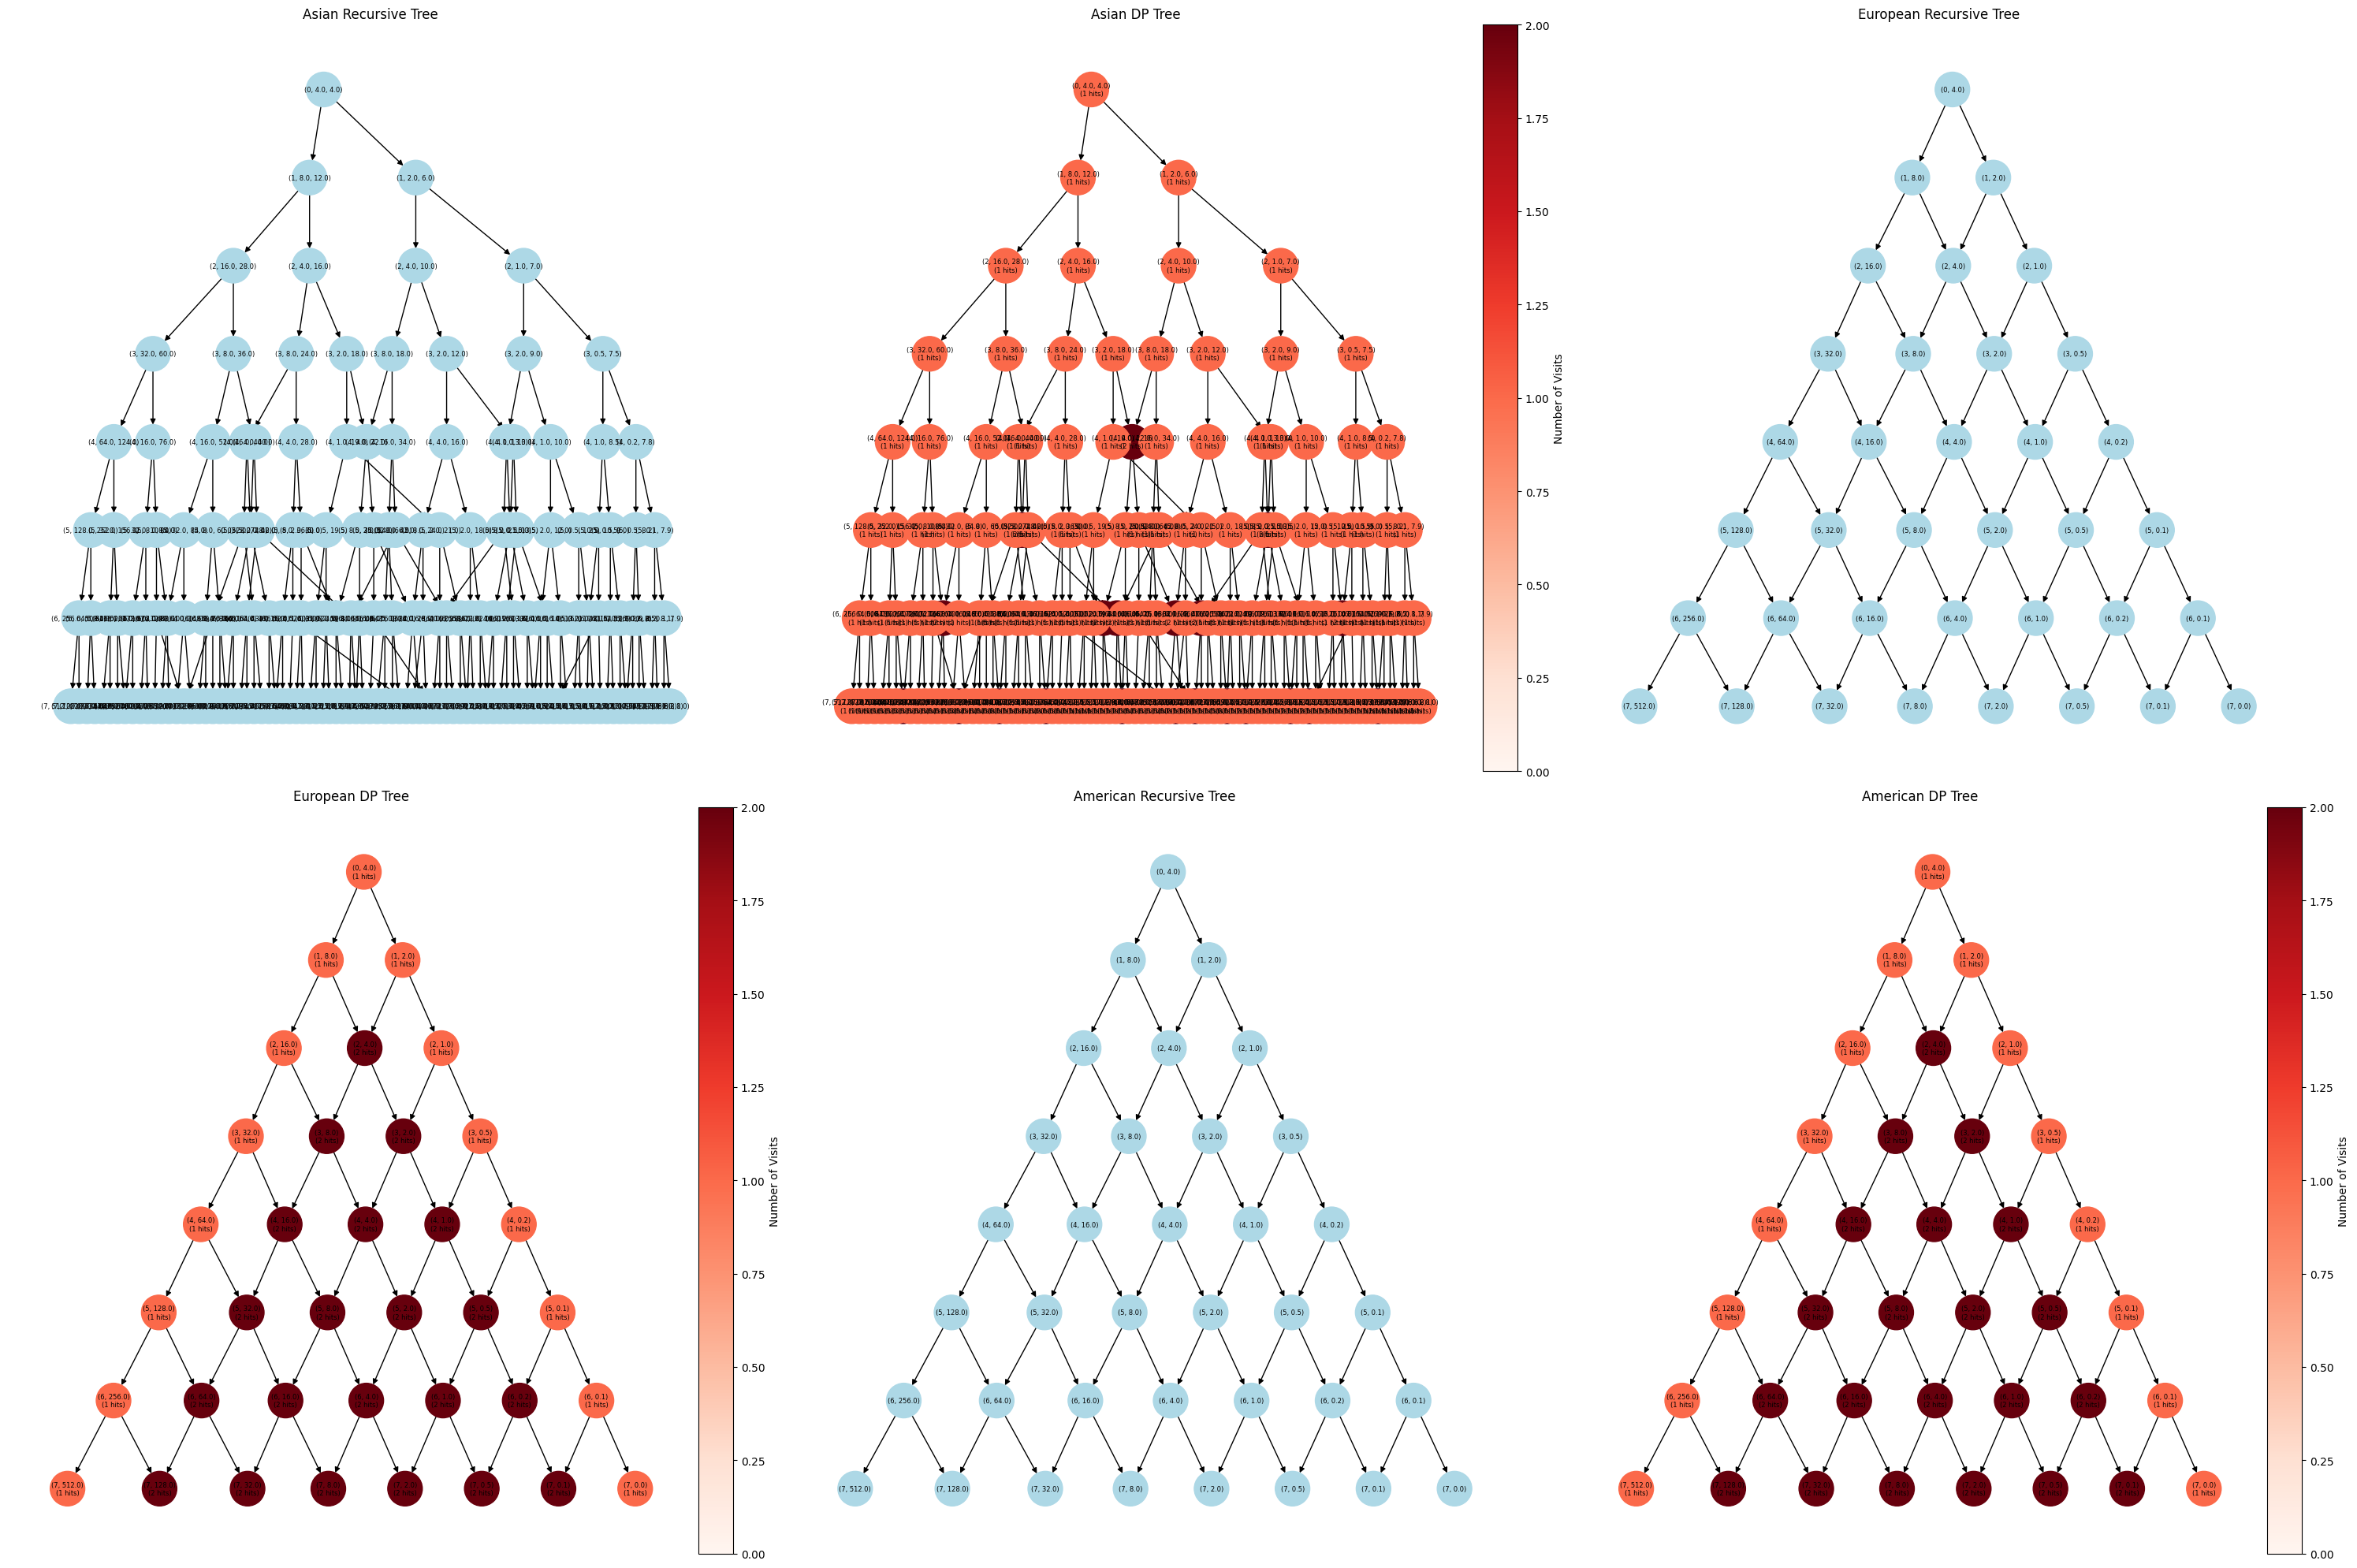


Asian Recursive:
Total nodes: 196
Total visits: 217
Max visits to any node: 2

Asian DP:
Total nodes: 196
Total visits: 217
Max visits to any node: 2

European Recursive:
Total nodes: 36
Total visits: 57
Max visits to any node: 2

European DP:
Total nodes: 36
Total visits: 57
Max visits to any node: 2

American Recursive:
Total nodes: 36
Total visits: 57
Max visits to any node: 2

American DP:
Total nodes: 36
Total visits: 57
Max visits to any node: 2


In [75]:

def count_visits(option_type, n, s, y=None, memo=None):
    """Count how many times each node would be visited in a recursive calculation"""
    if memo is None:
        memo = {}
    
    if y is not None:  # Asian
        key = (n, s, y)
    else:  # European/American
        key = (n, s)
        
    if key in memo:
        memo[key] += 1
        return memo
        
    memo[key] = 1
    
    if n < T:
        us, ds = u * s, d * s
        if y is not None:  # Asian
            count_visits(option_type, n + 1, us, y + us, memo)
            count_visits(option_type, n + 1, ds, y + ds, memo)
        else:  # European/American
            count_visits(option_type, n + 1, us, memo=memo)
            count_visits(option_type, n + 1, ds, memo=memo)
    
    return memo

def build_tree_with_hits(option_type, depth=6):  
    graph = nx.DiGraph()
    dp_mode = "DP" in option_type
    opt_key = option_type.split()[0].lower()
    
    # Get visit counts for recursive calculation
    if "Asian" in option_type:
        visits = count_visits(opt_key, 0, S0, S0)
    else:
        visits = count_visits(opt_key, 0, S0)
    
    if "Asian" in option_type:
        def build_asian_tree(n, s, y, parent=None):
            if n > depth:
                return
                
            label = f"({n}, {s:.1f}, {y:.1f})"
            hits = visits.get((n, s, y), 0) if dp_mode else visits.get((n, s, y), 0)
            graph.add_node(label, hits=hits)
            
            if parent:
                graph.add_edge(parent, label)
            
            if n < depth:
                build_asian_tree(n + 1, s * u, y + (s * u), label)
                build_asian_tree(n + 1, s * d, y + (s * d), label)
        
        build_asian_tree(0, S0, S0)
        
    else:  # European and American options
        def build_euro_tree(n, s, parent=None):
            if n > depth:
                return
                
            label = f"({n}, {s:.1f})"
            hits = visits.get((n, s), 0) if dp_mode else visits.get((n, s), 0)
            graph.add_node(label, hits=hits)
            
            if parent:
                graph.add_edge(parent, label)
            
            if n < depth:
                build_euro_tree(n + 1, s * u, label)
                build_euro_tree(n + 1, s * d, label)
        
        build_euro_tree(0, S0)
    
    return graph

# Heat maps
option_types = [
    "Asian Recursive", "Asian DP",
    "European Recursive", "European DP",
    "American Recursive", "American DP"
]
graphs = {opt: build_tree_with_hits(opt, depth=7) for opt in option_types}

fig, axes = plt.subplots(2, 3, figsize=(30, 20))  # Increased figure size
axes = axes.flatten()

for i, opt in enumerate(option_types):
    ax = axes[i]
    plt.sca(ax)
    graph = graphs[opt]
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")
    
    hits = [graph.nodes[node]['hits'] for node in graph.nodes()]
    max_hits = max(hits) if hits else 1
    
    if "DP" in opt:
        node_colors = [plt.cm.Reds(h/max_hits) for h in hits]
        labels = {node: f"{node}\n({graph.nodes[node]['hits']} hits)" 
                 for node in graph.nodes()}
    else:
        node_colors = ['lightblue' for _ in hits]
        labels = {node: str(node) for node in graph.nodes()}
    
    nx.draw(graph, pos,
            node_color=node_colors,
            node_size=1000,  
            with_labels=True,
            labels=labels,
            font_size=6,  
            ax=ax)
    
    if "DP" in opt and max_hits > 0:
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                                  norm=plt.Normalize(vmin=0, vmax=max_hits))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(sm, cax=cax, label='Number of Visits')
    
    ax.set_title(f"{opt} Tree")

plt.tight_layout()
plt.show()

# Print some statistics about the trees
for opt in option_types:
    graph = graphs[opt]
    total_hits = sum(graph.nodes[node]['hits'] for node in graph.nodes())
    max_hits = max(graph.nodes[node]['hits'] for node in graph.nodes())
    print(f"\n{opt}:")
    print(f"Total nodes: {len(graph.nodes())}")
    print(f"Total visits: {total_hits}")
    print(f"Max visits to any node: {max_hits}")

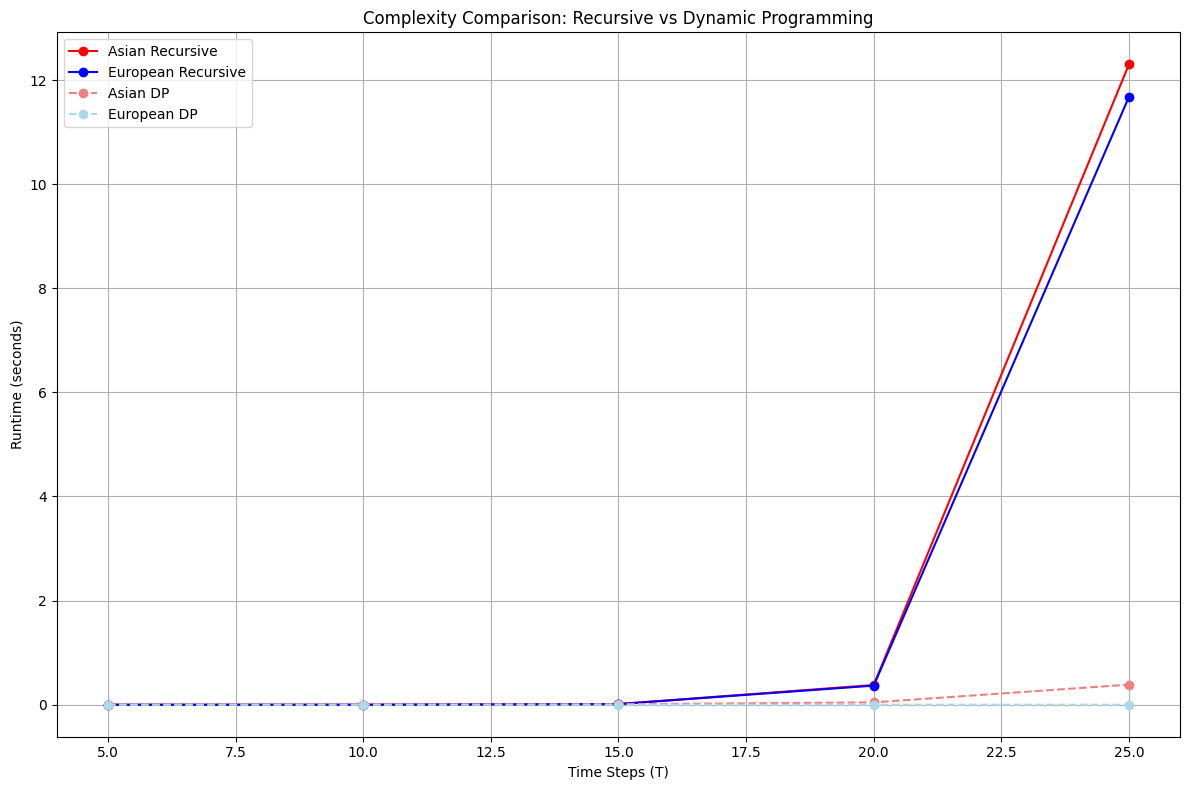


Runtime Results (seconds):
    T  Asian Recursive  European Recursive  Asian DP  European DP
0   5           0.0000              0.0000    0.0000       0.0000
1  10           0.0004              0.0005    0.0009       0.0000
2  15           0.0130              0.0114    0.0086       0.0001
3  20           0.3786              0.3667    0.0452       0.0001
4  25          12.3016             11.6753    0.3857       0.0002

Growth Analysis:

Asian Recursive average growth ratio between steps: 27.83

European Recursive average growth ratio between steps: 29.00

Asian DP average growth ratio between steps: 13.54

European DP average growth ratio between steps: 2.02


In [76]:
# Create a function to run all calculations for a given T
def run_calculations_for_T(T_value):
    global T
    T = T_value
    
    # Clear caches
    asian_option_dp.cache_clear()
    european_option_dp.cache_clear()
    american_option_dp.cache_clear()
    
    # Run calculations and store times
    start = time.time()
    asian_price_recursive = asian_option_recursive(0, S0, S0)
    asian_recursive_time = time.time() - start
    
    start = time.time()
    european_price_recursive = european_option_recursive(0, S0)
    european_recursive_time = time.time() - start
    
    start = time.time()
    asian_price_dp = asian_option_dp(0, S0, S0)
    asian_dp_time = time.time() - start
    
    start = time.time()
    european_price_dp = european_option_dp(0, S0)
    european_dp_time = time.time() - start
    
    return {
        'T': T_value,
        'Asian Recursive': asian_recursive_time,
        'European Recursive': european_recursive_time,
        'Asian DP': asian_dp_time,
        'European DP': european_dp_time
    }

# Run for different T values
T_values = [5, 10, 15, 20, 25]
results_by_T = [run_calculations_for_T(t) for t in T_values]

complexity_df = pd.DataFrame(results_by_T)

plt.figure(figsize=(12, 8))

# Plot all implementations
plt.plot(complexity_df['T'], complexity_df['Asian Recursive'], 'o-', label='Asian Recursive', color='red')
plt.plot(complexity_df['T'], complexity_df['European Recursive'], 'o-', label='European Recursive', color='blue')
plt.plot(complexity_df['T'], complexity_df['Asian DP'], 'o--', label='Asian DP', color='lightcoral')
plt.plot(complexity_df['T'], complexity_df['European DP'], 'o--', label='European DP', color='lightblue')

plt.xlabel('Time Steps (T)')
plt.ylabel('Runtime (seconds)')
plt.title('Complexity Comparison: Recursive vs Dynamic Programming')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual values
print("\nRuntime Results (seconds):")
print(complexity_df.round(4))

# Calculate growth ratios
print("\nGrowth Analysis:")
for column in ['Asian Recursive', 'European Recursive', 'Asian DP', 'European DP']:
    ratios = [complexity_df[column][i+1] / complexity_df[column][i] 
              for i in range(len(T_values)-1)]
    avg_ratio = sum(ratios) / len(ratios)
    print(f"\n{column} average growth ratio between steps: {avg_ratio:.2f}")